# Evaluation of PCMDI Metric Package

Name: Kaveh Karimi

ATS 421/521

Date: 07 Jun 2018


### Abstract

This notebook describes the process of installing and using _Program for Climate Model Diagnosis & Intercomparison_ ([PCMDI](https://pcmdi.llnl.gov/)) _Metric Package_ (`PMP`).

### Introduction

Evaluation of results of climate models is an important process for fine-tuning and improving the existing models and designing new ones. PCMDI Metric Package (`PMP`) is an open-source library, created and maintained by Lawrence Livermore National Laboratory, that helps with comparison of model outputs and observations (_Glecker et al. 2018_).

The `PMP` prototype was initially released in 2015 and now has reached version 1.1.2. The focus of ongoing development is on CMIP6 compatibility. Unfortunately, this has caused some backward incompatibility for CMIP5 models, and due to lack of documentation for older versions of the library, it is hard to validate the results of runs of `PMP` on old data.

During the process of investigating `PMP`, I created a [`docker`](https://www.docker.com/) image that wraps the latest version of `PMP` and provides an image for this package that can be installed on any machine, using the `docker` platform. See the instructions in `Appendix A` at the end of this report.

### Model/Data Description

For testing the `PMP` package, I chose two CMIP5 models and compared their outputs against observation data from the Global Precipitation Climatology Project (GPCP).

Observation data was obtained from https://www.earthsystemcog.org/search/obs4mips/ (see its metadata in `Appendix B`). It contains precipitation data from 1979 to 2017.

As for models, `MIROC5` and `MRI-CGCM3` are chosen. They both contain data from 1980 to 2010 and all their attributes are the same: The experiments are 10- or 30-year runs initialized in the year 1980, with a monthly time frequency. They are part of `r1i1p1` ensemble; the `r`, `i`, and `p` numbers indicate models `realization`, `initialization`, and `perturbed physics` parameters (_Taylor et al. 2011_).

The following cells show average precipitation for the three datasets, the two models and real observation, over their time period. As can be seen in the contour plots, the range of precipitation difference between model and real observation is wider for `MRI-CGCM3` compared to `MIROC5`.  The `PMP` output also shows this difference.

In [1]:
% matplotlib inline

import json

import cartopy.crs as ccrs
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interpn
import xarray as xr

def tabulate(data):
    """ Converts a list of list to an HTML table. Each item in each list would be a cell value in the table
    """
    return '<table style="font-size: large;"><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format(
                '</td><td>'.join(str(cell) for cell in row)
            ) for row in data
        )
    )

PR_PATHS = {
    'OBS': './pr/obs/processed/atm/mo/pr/GPCP/ac/pr_GPCP_000001-000012_ac.nc',
    'MIROC5': './pr/MIROC5/processed/pr_Amon_MIROC5_decadal1980_r1i1p1_198101-201012.nc',
    'MRI-CGCM3': './pr/MRI-CGCM3/processed/pr_Amon_MRI-CGCM3_decadal1980_r1i1p1_198101-201012.nc'
}

PCMDI_RESULTS_PATH = {
    'pr': './results/pr/decadal1980/pr_2.5x2.5_esmf_linear_metrics.json'
}

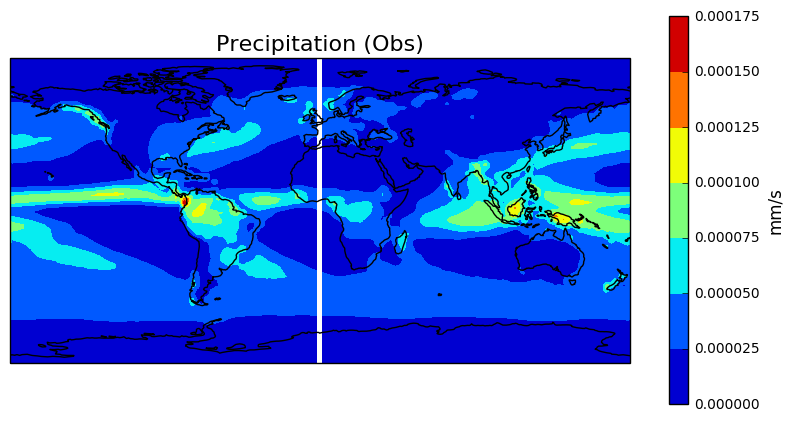

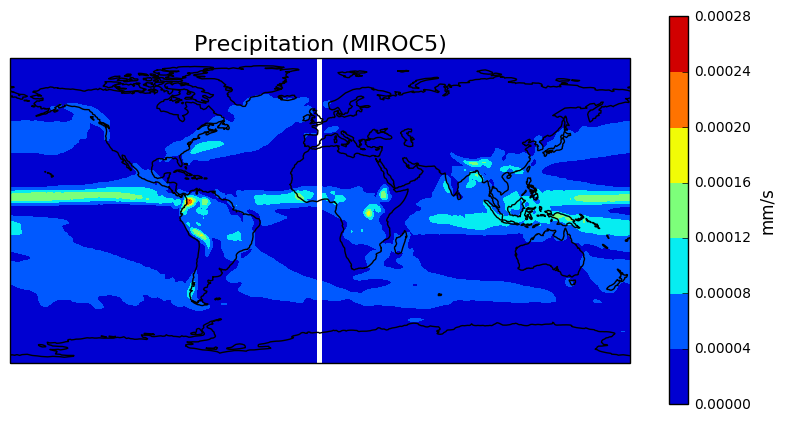

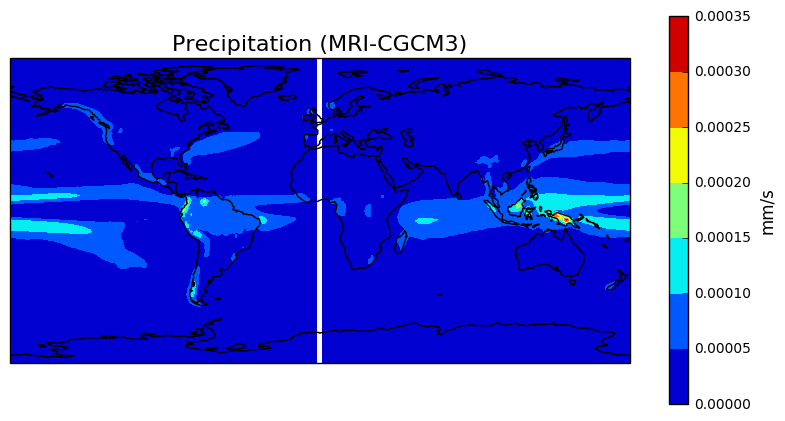

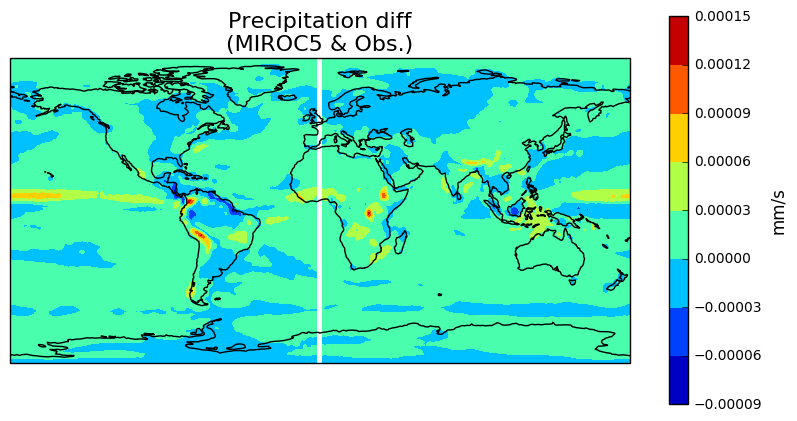

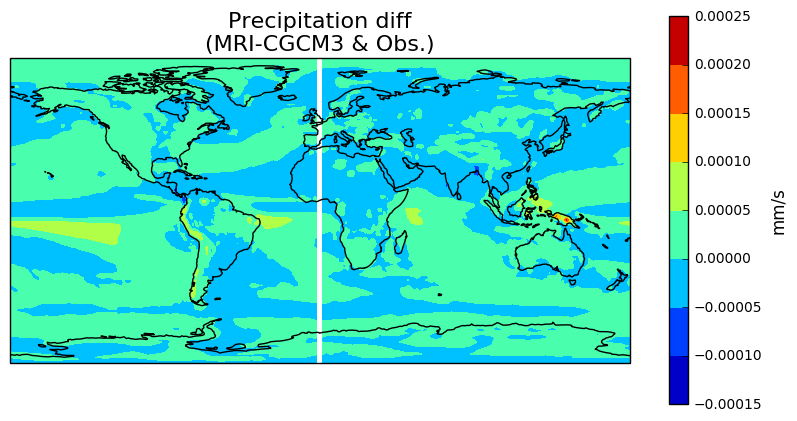

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

OBS_pr = xr.open_dataset(PR_PATHS['OBS']).mean(dim='time')
MIROC5_pr = xr.open_dataset(PR_PATHS['MIROC5']).mean(dim='time')
MRI_CGCM3_pr = xr.open_dataset(PR_PATHS['MRI-CGCM3']).mean(dim='time')

lat_min = float(max(OBS_pr.lat.min(), MIROC5_pr.lat.min(), MRI_CGCM3_pr.lat.min()))
lat_max = float(min(OBS_pr.lat.max(), MIROC5_pr.lat.max(), MRI_CGCM3_pr.lat.max()))
lon_min = float(max(OBS_pr.lon.min(), MIROC5_pr.lon.min(), MRI_CGCM3_pr.lon.min()))
lon_max = float(min(OBS_pr.lon.max(), MIROC5_pr.lon.max(), MRI_CGCM3_pr.lon.max()))

grid_x, grid_y = np.mgrid[lat_min:lat_max, lon_min:lon_max]

# Regridding observation and the models
OBS_pr_regridded = interpn((OBS_pr.pr.lat, OBS_pr.pr.lon), np.array(OBS_pr.pr), (grid_x, grid_y), method='linear')
MIROC5_pr_regridded = interpn((MIROC5_pr.lat, MIROC5_pr.lon), np.array(MIROC5_pr.pr), (grid_x, grid_y), method='linear')
MRI_CGCM3_pr_regridded = interpn((MRI_CGCM3_pr.lat, MRI_CGCM3_pr.lon), np.array(MRI_CGCM3_pr.pr), (grid_x, grid_y), method='linear')

# Plot observation
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid_y, grid_x, OBS_pr_regridded, transform=ccrs.PlateCarree())
cb = plt.colorbar()
cb.ax.set_ylabel('mm/s', fontsize=12)
plt.title('Precipitation (Obs)', fontsize=16)
ax.coastlines()
plt.show()

# Plot MIROC5
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid_y, grid_x, MIROC5_pr_regridded, transform=ccrs.PlateCarree())
cb = plt.colorbar()
cb.ax.set_ylabel('mm/s', fontsize=12)
plt.title('Precipitation (MIROC5)', fontsize=16)
ax.coastlines()
plt.show()

# Plot MRI-CGCM3
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid_y, grid_x, MRI_CGCM3_pr_regridded, transform=ccrs.PlateCarree())
cb = plt.colorbar()
cb.ax.set_ylabel('mm/s', fontsize=12)
plt.title('Precipitation (MRI-CGCM3)', fontsize=16)
ax.coastlines()
plt.show()

# Plot MIROC5 and Obs diff
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid_y, grid_x, MIROC5_pr_regridded - OBS_pr_regridded, transform=ccrs.PlateCarree())
cb = plt.colorbar()
cb.ax.set_ylabel('mm/s', fontsize=12)
plt.title('Precipitation diff\n(MIROC5 & Obs.)', fontsize=16)
ax.coastlines()
plt.show()

# Plot MRI-CGCM3 and Obs diff
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(grid_y, grid_x, MRI_CGCM3_pr_regridded - OBS_pr_regridded, transform=ccrs.PlateCarree())
cb = plt.colorbar()
cb.ax.set_ylabel('mm/s', fontsize=12)
plt.title('Precipitation diff\n(MRI-CGCM3 & Obs.)', fontsize=16)
ax.coastlines()
plt.show()

### Methodology

`pcmdi_metrics` requires a parameter file for each model. The template for a parameter file can be found on [`Github`](https://github.com/PCMDI/pcmdi_metrics/blob/v1.1.1/doc/parameter_files/input_parameter_file_all_options.py). The main required attributes are models paths, variables, period, and realization (model ensemble). Most attributes, such as input, output, and model names, can be set using a template, which is filled automatically by `pcmdi_metrics`. It allows users to run the script over multiple models and variables with similar attributes.

The observation datasets go in a nested folder matching the following pattern in the path specified in `reference_data_path`: `(realm)/(frequency)/(variable)/(source_id)/ac`

I adjusted the last two parts of the path, i.e `(source_id)` and `ac`, by trial and error, because I could find no documentation on that pattern at the time of doing this project.

The next cell shows input parameters created for this project. All regridding attributes are similar to the demo file shipped with `pcmdi_metrics`.

### Input parameters

```python
# this 'template' is used by PMP to construct file names and paths that correspond to the location of the model and observatinal data.
filename_template = "%(variable)_Amon_%(model_version)_decadal1980_%(realization)_%(period).nc"

# case_id helps us differentiate between results of different paramter files
case_id = 'decadal1980'

# List of models
test_data_set = ['MRI-CGCM3', 'MIROC5']

## Model data location
test_data_path = 'pr/%(model_version)/processed/'

## Root path for observations
reference_data_path = 'pr/obs/processed/'

# Output path
metrics_output_path = 'results/pr/%(case_id)/'  

# OBSERVATIONS TO USE: CHOICES INCLUDE 'default','alternate1','alternate2',... AND ARE VARIABLE DEPENDENT 
reference_data_set = ['default']

# List of variables to compute statistics for
vars = ['pr']  

# INTERPOLATION (REGRIDDING) OPTIONS

# First our target grid, i.e the final grid onto which both model and obs will be put
# OPTIONS: '2.5x2.5' or an actual cdms2 grid object
target_grid        = '2.5x2.5'

# Now let's select which cdms2 regrid tool we will use
regrid_tool       = 'esmf' 

# Some regrid tools also require to specify which method of regriding to use
# OPTIONS: 'linear','conservative', only if tool is esmf
regrid_method     = 'linear'

# SIMULATION PARAMETERS (required in PMP v1.1)

# PERIOD OF CLIMATOLOGY
period = '198101-201012'

# MODEL REALIZATION
realization = 'r1i1p1'
```

After defining the input parameters, I created inputs and outputs folders based on the name templates used for those attributes. The final structure is as follows:

```bash
pr
├── input_parameters.py
├── MIROC5
│   ├── processed
│   │   └── pr_Amon_MIROC5_decadal1980_r1i1p1_198101-201012.nc
│   └── raw
│       ├── pr_Amon_MIROC5_decadal1980_r1i1p1_198101-199012.nc
│       ├── pr_Amon_MIROC5_decadal1980_r1i1p1_199101-200012.nc
│       └── pr_Amon_MIROC5_decadal1980_r1i1p1_200101-201012.nc
├── MRI-CGCM3
│   └── processed
│       └── pr_Amon_MRI-CGCM3_decadal1980_r1i1p1_198101-201012.nc
└── obs
    ├── processed
    │   └── atm
    │       └── mo
    │           └── pr
    │               └── GPCP
    │                   └── ac
    │                       └── pr_GPCP_000001-000012_ac.nc
    └── raw
        ├── GPCP_precip_SG-V2.3_TechNote_180510.pdf
        ├── metadata
        └── pr_GPCP-SG_L3_v2.3_197901-201710.nc
```

`raw` folders contain original data downloaded from [ESGF](https://www.earthsystemcog.org/) and processed folders contain modified datasets to be used as inputs of `pcmdi_metrics`. If there is no `raw` folder and only a `processed` folder under a category, it means data is consumed by the script as it was downloaded, without any further processing (e.g. `MRI-CGCM3`). As for case of `MIROC5`, the data came in three parts and I concatenated them to be comparable with the other model. I sliced observation data to match the time period of the models.

After this step, I used the following script to calculate statistics for the given models in the input parameter file.

```python
import os
import shlex
import subprocess
import sys

import genutil
import pcmdi_metrics

def analyze(param_file):
    """ `param_file` is the path to input parameters file """
    
    # Initialize `pcmdi_metrics` with a given input parameters file
    cmd = 'pcmdi_metrics_driver.py -p {}'.format(param_file)
    pmp = subprocess.Popen(shlex.split(cmd))
    pmp.wait()
    
    # Load input parameters file into the environment
    sys.path.insert(0, os.path.dirname(param_file))
    exec('import {} as pmp_param'.format(os.path.basename(param_file)[:-3]))

    # Start the process for calculating model statistics
    loc = genutil.StringConstructor(os.path.join(pmp_param.metrics_output_path))
    for att in ['case_id', 'model_version', 'period', 'realization']:
        if hasattr(pmp_param, att):
            setattr(loc, att, getattr(pmp_param, att))

analyze('./pr/input_parameters')
```


_Note: the script can be tested in a `pcmdi_metrics` enabled environment._

### Results

In [3]:
# Open the resul `json` file
with open(PCMDI_RESULTS_PATH['pr'], 'r') as f:
    PCMDI_pr_analysis_result = json.loads(f.read())

# Iterate over models in the result and show their description
for model in ['MIROC5', 'MRI-CGCM3']:
    display(HTML('<h3 style="border-bottom: 1px solid #000; width: 50%;">{}</h3>'.format(model)))
    for k, v in PCMDI_pr_analysis_result['RESULTS'][model]['SimulationDescription'].items():
        display(HTML('<b>{}</b>: {}'.format(k, v)))

results = {
    'std_xyt': {
        'title': '<h2>Spatial and Temporal Standard Deviation</h2>',
        'data': []
    },
    'rms_xyt': {
        'title': '<h2>Spatial and Temporal Root Mean Square</h2>',
        'data': []
    },
    'mean_xy': {
        'title': '<h2>Area Mean (area weighted)</h2>',
        'data': []
    },
    'mae_xy': {
        'title': '<h2>Average of Absolute Difference Between Model And Observation</h2>',
        'data': []
    }
}

# Iterate over regions, models, and statistics outputs from the result file and prepare them for display
for k, v in results.items():
    v['data'].append(['Model', 'Global', 'SHEX', 'Tropics', 'NHEX'])
    for model in ['MIROC5', 'MRI-CGCM3']:
        result_model = [model]
        for area in ['global', 'SHEX', 'TROPICS', 'NHEX']:
            result_model.append(PCMDI_pr_analysis_result['RESULTS'][model]['default']['r1i1p1'][area][k]['ann'])
        v['data'].append(result_model)

for result in results.values():
    display(HTML(result['title']))
    display(HTML(tabulate(result['data'])))

Model,Global,SHEX,Tropics,NHEX
MIROC5,2.797,1.609,3.594,1.695
MRI-CGCM3,3.122,1.536,4.112,1.679


Model,Global,SHEX,Tropics,NHEX
MIROC5,0.797,0.602,1.068,0.450
MRI-CGCM3,0.847,0.377,1.290,0.433


Model,Global,SHEX,Tropics,NHEX
MIROC5,3.202,2.901,3.792,2.323
MRI-CGCM3,2.908,2.581,3.439,2.172


Model,Global,SHEX,Tropics,NHEX
MIROC5,3.355,1.684,4.266,2.055
MRI-CGCM3,3.527,1.610,4.589,1.957


In [4]:
EARTH_RADIUS = 6371 * 1000        # Earth radius in meters

OBS_bands_surface_areas = 2 * np.pi * (EARTH_RADIUS ** 2) * np.diff(np.sin(np.radians(OBS_pr.lat)))
MIROC5_bands_surface_areas = 2 * np.pi * (EARTH_RADIUS ** 2) * np.diff(np.sin(np.radians(MIROC5_pr.lat)))
MRI_CGCM3_bands_surface_areas = 2 * np.pi * (EARTH_RADIUS ** 2) * np.diff(np.sin(np.radians(MRI_CGCM3_pr.lat)))

OBS_precip_zonal = OBS_pr.pr.mean('lon')
MIROC5_precip_zonal = MIROC5_pr.pr.mean('lon')
MRI_CGCM3_precip_zonal = MRI_CGCM3_pr.pr.mean('lon')

# Calculate global average precipitation using latitude bands as weights
OBS_global_avg_pr = np.average((OBS_precip_zonal.values[:-1] + OBS_precip_zonal[1:]) / 2, weights=OBS_bands_surface_areas)
MIROC5_global_avg_pr = np.average((MIROC5_precip_zonal.values[:-1] + MIROC5_precip_zonal[1:]) / 2, weights=MIROC5_bands_surface_areas)
MRI_CGCM3_global_avg_pr = np.average((MRI_CGCM3_precip_zonal.values[:-1] + MRI_CGCM3_precip_zonal[1:]) / 2, weights=MRI_CGCM3_bands_surface_areas)
print('Obs. Global Average Precipitation: {} mm/s\n'.format(OBS_global_avg_pr))
print('MIROC5 Global Average Precipitation: {} mm/s\n'.format(MIROC5_global_avg_pr))
print('MRI_CGCM3 Global Average Precipitation: {} mm/s\n'.format(MRI_CGCM3_global_avg_pr))

print('MIROC5 Global Average Precipitation: {} mm/s\n'.format(MIROC5_global_avg_pr - OBS_global_avg_pr))
print('MRI_CGCM3 Global Average Precipitation: {} mm/s\n'.format(MRI_CGCM3_global_avg_pr - OBS_global_avg_pr))

Obs. Global Average Precipitation: 3.1155922521919555e-05 mm/s

MIROC5 Global Average Precipitation: 3.706663341314722e-05 mm/s

MRI_CGCM3 Global Average Precipitation: 3.363216387316464e-05 mm/s

MIROC5 Global Average Precipitation: 5.910710891227662e-06 mm/s

MRI_CGCM3 Global Average Precipitation: 2.476241351245082e-06 mm/s



After running `pcmdi_metrics` over `MIROC5` and `MIR-CGCM3` models, a `json` file containing all the computed statistics was created and put in `./results/pr/decadal1980/pr_2.5x2.5_esmf_linear_metrics.json`. This file shows different statistics for different regions per model and also includes a brief explanation of what each result code means.

There are four regions in the results: Global, Tropics (between 30S and 30N), and Extra‐tropical zones of the Southern (90S–30S) and Northern (30N–90N) Hemispheres (SHEX and NHEX).

Here is a list of statistics calculated for each region, and their codes in the `json` file:

- rms_xyt: Spatial and Temporal Root Mean Square
- rms_xy: Spatial Root Mean Square
- rmsc_xy: Centered Spatial Root Mean Square
- bias_xy: Full Average of Model - Observation
- mae_xy: Full Average of Absolute Difference Between Model And Observation
- cor_xy: Spatial Correlation
- mean_xy: Area Mean (area weighted)
- std_xy: Spatial Standard Deviation
- std_xyt: Space-Time Standard Deviation

I also calculated global average precipitations for the models and observation without using `pcmdi_metrics`. The main ambiguity is around the units of results coming from `pcmdi_metrics`, which made it impossible to compare its outputs with the calculated global average values. It seems the outputs are normalized, but I could not find anything in the current documentation clarifying the meaning of the figures. `pcmdi_metrics` uses [`uv-cdat`](https://uvcdat.llnl.gov/) package for calculating its results, so the next step, in addition to contacting the developers, would be looking at that package for more info.

### Conclusions

The biggest challenge to working with `pcmdi_metrics` was finding an older version that could be used for CMIP5 data. At the time of this project, the package is undergoing constant modifications to make it ready for CMIP6 models, but unfortunately, it seems backward-compatibility is not a high priority. Lack of documentation and version history made this process more difficult.

The results calculated for the two models complied with the output of the precipitation demo that is shipped with the package, though their validity cannot be confirmed at this moment. If the result is wrong, it would be due to misconfiguration of input parameters or dataset processing.

The installer I created for this project should work better with the upcoming CMIP6 models.  I communicated with one of the developers of `pcmdi_metrics`, and he stated that they might include it in the package in future (Doutriaux, 2018).

### References

Doutriaux, Charles, personal e-mail communication, June 4, 2018.

Gleckler, Peter, Charles Doutriaux, Paul Durack, Karl Taylor, Yuying Zhang, Dean Williams, Erik Mason, and Jérôme Servonnat. “A More Powerful Reality Test for Climate Models.” Eos 97 (May 3, 2016). https://doi.org/10.1029/2016EO051663. 

pcmdi_metrics: Self Contained Packages to Run PCMDI Metrics. Python. 2015. Reprint, Program for Climate Model Diagnosis and Intercomparison, 2018. https://github.com/PCMDI/pcmdi_metrics.

Taylor, Karl E, V Balaji, Steve Hankin, Martin Juckes, Bryan Lawrence, and Stephen Pascoe. “CMIP5 Data Reference Syntax (DRS) and Controlled Vocabularies,” 2011, 14.

### Appendix A:

#### Using PCMDI Metric Package in Docker

For using `PCMDI` docker image, you need to install docker on your system. Docker has extensive documentation on its installation and usage. See the following resources for more info:

- [What is Docker?](https://www.docker.com/what-docker)
- [Documentation](https://docs.docker.com/)
- [Beginner Tutorial](https://github.com/docker/labs/blob/master/beginner/readme.md)

After making sure Docker is running on your machine, you can use the following commands in a terminal to get the package up and running.

`PCMDI` image is available here: https://hub.docker.com/r/kavehk/pcmdi/
You can pull it down by running `docker pull kavehk/pcmdi`.
The initial download and build might take up to 30 minutes.

After that, the image should be ready to use. For starting a `Jupyter` notebook with `pcmdi_metrics` in its environment, you can run the following command:

`docker run -it --init ${WORKSPACE}:/opt/notebooks -p ${PORT}:8888 kavehk/pcmdi bash -c ". activate pcmdi && jupyter notebook --notebook-dir=/opt/notebooks --ip='*' --port=8888 --no-browser --allow-root --NotebookApp.token=''`

Replace `${WORKSPACE}` and `${PORT}` with the path you want to save your `Jupyter` notebooks in and the port to run `Jupyter` server on. Then you can navigate to `localhost:${PORT}` in your browser and start using `Jupyter`.

You can also start a `bash` shell and use `pcmdi_metrics` directly in the shell. First, activate the shell by running this:

`docker run -it --init kavehk/pcmdi bash`

Then activate `conda` environment using `source activate pcmdi`. After this, you will be in a python environment with `pcmdi_metric` support within the docker container.

I have put the source for this docker image and a script wrapping the above commands on [`gitlab`](https://gitlab.com/kavehk/docker-pcmdi). You can check out the contents of `Dockerfile` there to see the steps for installing `pcmdi_mterics`. You can replicate those steps on any `Linux` (and probably `MacOS`) machine.

If you want to use `run.sh` script in that repository, first you need to build the docker image locally. To do so, first clone the repo (`git clone git@gitlab.com:kavehk/docker-pcmdi.git`) and then run the following command in a terminal from the root of the repo:

`docker build . -t pcmdi`

After the build is done, you can use `run.sh`. For example, to start a `Jupter` server by running `./run.sh jupyter ./example`.

There is a folder in that repo called `example`. It contains a notebook that shows how the package can be used. It runs the script on the demo data provided by `PCMDI`.

Feel free to file issues or questions here: [https://gitlab.com/kavehk/docker-pcmdi/issues](https://gitlab.com/kavehk/docker-pcmdi/issues)

### Appendix B:

#### Metadata:

##### Observation:

```
id = obs4MIPs.NASA-GSFC.GPCP-V2.3.atmos.mon.v20180519|esgf.nccs.nasa.gov
version = 20180519
_timestamp = 2018-05-22T15:54:13.927Z
access = HTTPServer, OPENDAP, LAS
cf_standard_name = precipitation_flux
data_node = esgf.nccs.nasa.gov
dataset_id_template_ = %(project)s.%(institute)s.%(source_id)s.%(realm)s.%(time_frequency)s
datetime_start = 1979-01-16T12:00:00Z
datetime_stop = 2017-10-01T12:00:00Z
east_degrees = 358.75
geos = ENVELOPE(-180.0, -1.25, 88.75, -88.75), ENVELOPE(1.25, 180.0, 88.75, -88.75)
geo_units = degrees_east
index_node = esgf.nccs.nasa.gov
instance_id = obs4MIPs.NASA-GSFC.GPCP-V2.3.atmos.mon.v20180519
institute = NASA-GSFC
master_id = obs4MIPs.NASA-GSFC.GPCP-V2.3.atmos.mon
metadata_format = THREDDS
model = Obs-GPCP
north_degrees = 88.75
number_of_aggregations = 2
number_of_files = 1
product = observations
project = obs4MIPs
realm = atmos
retracted = false
size = 19348352
source_id = GPCP-V2.3
south_degrees = -88.75
time_frequency = mon
variable = pr
variable_long_name = Precipitation
variable_units = kg m-2 s-1
west_degrees = 1.25 
```

##### MIROC5:

```
d = cmip5.output1.MIROC.MIROC5.decadal1980.mon.atmos.Amon.r1i1p1.v20120710|esgf-data1.diasjp.net
version = 20120710
_timestamp = 2016-10-01T11:24:00.239Z
access = LAS, OPENDAP, HTTPServer
cf_standard_names = geopotential_height, lagrangian_tendency_of_air_pressure, northward_wind, northward_wind, eastward_wind, eastward_wind, surface_temperature, surface_temperature, mole_fraction_of_ozone_in_air, surface_downward_northward_stress, surface_downward_eastward_stress, air_temperature, air_temperature, air_temperature, air_temperature, air_temperature, wind_speed, surface_snow_and_ice_sublimation_flux, net_downward_radiative_flux_at_top_of_atmosphere_model, toa_outgoing_shortwave_flux_assuming_clear_sky, toa_outgoing_shortwave_flux, surface_upwelling_shortwave_flux_in_air_assuming_clear_sky, surface_upwelling_shortwave_flux_in_air, toa_incoming_shortwave_flux, surface_downwelling_shortwave_flux_in_air_assuming_clear_sky, surface_downwelling_shortwave_flux_in_air, toa_outgoing_longwave_flux_assuming_clear_sky, toa_outgoing_longwave_flux, surface_upwelling_longwave_flux_in_air, surface_downwelling_longwave_flux_in_air_assuming_clear_sky, surface_downwelling_longwave_flux_in_air, air_pressure_at_sea_level, air_pressure_at_sea_level, surface_air_pressure, atmosphere_water_vapor_content, snowfall_flux, convective_precipitation_flux, precipitation_flux, precipitation_flux, mole_fraction_of_nitrous_oxide_in_air, atmosphere_net_upward_convective_mass_flux, specific_humidity, specific_humidity, relative_humidity, relative_humidity, surface_upward_sensible_heat_flux, surface_upward_latent_heat_flux, water_evaporation_flux, atmosphere_mass_of_carbon_dioxide, atmosphere_cloud_condensed_water_content, mass_fraction_of_cloud_liquid_water_in_air, cloud_area_fraction, atmosphere_cloud_ice_content, mass_fraction_of_cloud_ice_in_air, cloud_area_fraction_in_atmosphere_layer, mole_fraction_of_methane_in_air, air_pressure_at_convective_cloud_top, air_pressure_at_convective_cloud_base
cmor_table = Amon
data_node = esgf-data1.diasjp.net
dataset_id_template_ = cmip5.%(product)s.%(institute)s.%(model)s.%(experiment)s.%(time_frequency)s.%(realm)s.%(cmor_table)s.%(ensemble)s
datetime_start = 1981-01-16T12:00:00Z
datetime_stop = 2010-12-16T12:00:00Z
drs_id = cmip5.output1.MIROC.MIROC5.decadal1980.mon.atmos.Amon.r1i1p1
east_degrees = 358.59375
ensemble = r1i1p1
experiment = decadal1980
experiment_familys = Decadal, All
forcing = GHG, SA, Oz, LU, Sl, Vl, SS, Ds, BC, MD, OC (GHG includes CO2, N2O, methane, and fluorocarbons; Oz includes OH and H2O2; LU excludes change in lake fraction)
format = netCDF, CF-1.4
geos = ENVELOPE(0.0, 180.0, 88.927735, -88.927735), ENVELOPE(-180.0, -1.40625, 88.927735, -88.927735)
height_bottom = 0.997499
height_top = 1000.0
height_units = Pa
index_node = esgf-node.llnl.gov
instance_id = cmip5.output1.MIROC.MIROC5.decadal1980.mon.atmos.Amon.r1i1p1.v20120710
institute = MIROC
master_id = cmip5.output1.MIROC.MIROC5.decadal1980.mon.atmos.Amon.r1i1p1
metadata_format = THREDDS
model = MIROC5
north_degrees = 88.927734
number_of_aggregations = 114
number_of_files = 160
product = output1
project = CMIP5
realm = atmos
retracted = false
size = 16109421000
south_degrees = -88.927734
time_frequency = mon
timestamp = 2016-06-25T01:39:21Z
variables = zg, wap, vas, va, uas, ua, tsAdjust, ts, tro3, tauv, tauu, tasmin, tasmax, tasAdjust, tas, ta, sfcWind, sbl, rtmt, rsutcs, rsut, rsuscs, rsus, rsdt, rsdscs, rsds, rlutcs, rlut, rlus, rldscs, rlds, pslAdjust, psl, ps, prw, prsn, prc, prAdjust, pr, n2oglobal, mc, huss, hus, hurs, hur, hfss, hfls, evspsbl, co2mass, clwvi, clw, clt, clivi, cli, cl, ch4global, cct, ccb
variable_long_names = Geopotential Height, omega (=dp/dt), Northward Near-Surface Wind, Northward Wind, Eastward Near-Surface Wind, Eastward Wind, Bias-Corrected Surface Temperature, Surface Temperature, Mole Fraction of O3, Surface Downward Northward Wind Stress, Surface Downward Eastward Wind Stress, Daily Minimum Near-Surface Air Temperature, Daily Maximum Near-Surface Air Temperature, Bias-Corrected Near-Surface Air Temperature, Near-Surface Air Temperature, Air Temperature, Near-Surface Wind Speed, Surface Snow and Ice Sublimation Flux, Net Downward Flux at Top of Model, TOA Outgoing Clear-Sky Shortwave Radiation, TOA Outgoing Shortwave Radiation, Surface Upwelling Clear-Sky Shortwave Radiation, Surface Upwelling Shortwave Radiation, TOA Incident Shortwave Radiation, Surface Downwelling Clear-Sky Shortwave Radiation, Surface Downwelling Shortwave Radiation, TOA Outgoing Clear-Sky Longwave Radiation, TOA Outgoing Longwave Radiation, Surface Upwelling Longwave Radiation, Surface Downwelling Clear-Sky Longwave Radiation, Surface Downwelling Longwave Radiation, Bias-Corrected Sea Level Pressure, Sea Level Pressure, Surface Air Pressure, Water Vapor Path, Snowfall Flux, Convective Precipitation, Bias-Corrected Precipitation, Precipitation, Global Mean Mole Fraction of N2O, Convective Mass Flux, Near-Surface Specific Humidity, Specific Humidity, Near-Surface Relative Humidity, Relative Humidity, Surface Upward Sensible Heat Flux, Surface Upward Latent Heat Flux, Evaporation, Total Atmospheric Mass of CO2, Condensed Water Path, Mass Fraction of Cloud Liquid Water, Total Cloud Fraction, Ice Water Path, Mass Fraction of Cloud Ice, Cloud Area Fraction, Global Mean Mole Fraction of CH4, Air Pressure at Convective Cloud Top, Air Pressure at Convective Cloud Base
variable_units = m, Pa s-1, m s-1, m s-1, m s-1, m s-1, K, K, 1e-9, Pa, Pa, K, K, K, K, K, m s-1, kg m-2 s-1, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, Pa, Pa, Pa, kg m-2, kg m-2 s-1, kg m-2 s-1, kg m-2 s-1, kg m-2 s-1, 1e-9, kg m-2 s-1, 1, 1, %, %, W m-2, W m-2, kg m-2 s-1, kg, kg m-2, 1, %, kg m-2, 1, %, 1e-9, Pa, Pa
west_degrees = 0.0 
```

##### MIR-CGCM3:

```
id = cmip5.output1.MRI.MRI-CGCM3.decadal1980.mon.atmos.Amon.r1i1p1.v20120701|esgf-data1.diasjp.net
version = 20120701
_timestamp = 2016-09-21T10:57:43.943Z
access = LAS, OPENDAP, HTTPServer
cf_standard_names = geopotential_height, lagrangian_tendency_of_air_pressure, northward_wind, northward_wind, eastward_wind, eastward_wind, surface_temperature, surface_downward_northward_stress, surface_downward_eastward_stress, air_temperature, air_temperature, air_temperature, air_temperature, wind_speed, surface_snow_and_ice_sublimation_flux, toa_outgoing_shortwave_flux_assuming_clear_sky, toa_outgoing_shortwave_flux, surface_upwelling_shortwave_flux_in_air_assuming_clear_sky, surface_upwelling_shortwave_flux_in_air, toa_incoming_shortwave_flux, surface_downwelling_shortwave_flux_in_air_assuming_clear_sky, surface_downwelling_shortwave_flux_in_air, toa_outgoing_longwave_flux_assuming_clear_sky, toa_outgoing_longwave_flux, surface_upwelling_longwave_flux_in_air, surface_downwelling_longwave_flux_in_air_assuming_clear_sky, surface_downwelling_longwave_flux_in_air, air_pressure_at_sea_level, surface_air_pressure, atmosphere_water_vapor_content, snowfall_flux, convective_precipitation_flux, precipitation_flux, atmosphere_net_upward_convective_mass_flux, specific_humidity, specific_humidity, relative_humidity, relative_humidity, surface_upward_sensible_heat_flux, surface_upward_latent_heat_flux, water_evaporation_flux, atmosphere_cloud_condensed_water_content, mass_fraction_of_cloud_liquid_water_in_air, cloud_area_fraction, atmosphere_cloud_ice_content, mass_fraction_of_cloud_ice_in_air, cloud_area_fraction_in_atmosphere_layer, convection_time_fraction, air_pressure_at_convective_cloud_top, air_pressure_at_convective_cloud_base
cmor_table = Amon
data_node = esgf-data1.diasjp.net
dataset_id_template_ = cmip5.%(product)s.%(institute)s.%(model)s.%(experiment)s.%(time_frequency)s.%(realm)s.%(cmor_table)s.%(ensemble)s
datetime_start = 1981-01-16T12:00:00Z
datetime_stop = 2010-12-16T12:00:00Z
drs_id = cmip5.output1.MRI.MRI-CGCM3.decadal1980.mon.atmos.Amon.r1i1p1
east_degrees = 358.875
ensemble = r1i1p1
experiment = decadal1980
experiment_familys = Decadal, All
forcing = GHG, SA, Oz, LU, Sl, Vl, BC, OC (GHG includes CO2, CH4, N2O, CFC-11, CFC-12, and HCFC-22)
format = netCDF, CF-1.4
height_bottom = 0.994996
height_top = 40.0
height_units = Pa
index_node = esgf-node.llnl.gov
instance_id = cmip5.output1.MRI.MRI-CGCM3.decadal1980.mon.atmos.Amon.r1i1p1.v20120701
institute = MRI
master_id = cmip5.output1.MRI.MRI-CGCM3.decadal1980.mon.atmos.Amon.r1i1p1
metadata_format = THREDDS
model = MRI-CGCM3
north_degrees = 89.14152
number_of_aggregations = 98
number_of_files = 72
product = output1
project = CMIP5
realm = atmos
retracted = false
size = 25438054260
south_degrees = -89.14152
time_frequency = mon
timestamp = 2016-06-26T14:07:17Z
variables = zg, wap, vas, va, uas, ua, ts, tauv, tauu, tasmin, tasmax, tas, ta, sfcWind, sbl, rsutcs, rsut, rsuscs, rsus, rsdt, rsdscs, rsds, rlutcs, rlut, rlus, rldscs, rlds, psl, ps, prw, prsn, prc, pr, mc, huss, hus, hurs, hur, hfss, hfls, evspsbl, clwvi, clw, clt, clivi, cli, cl, ci, cct, ccb
variable_long_names = Geopotential Height, omega (=dp/dt), Northward Near-Surface Wind, Northward Wind, Eastward Near-Surface Wind, Eastward Wind, Surface Temperature, Surface Downward Northward Wind Stress, Surface Downward Eastward Wind Stress, Daily Minimum Near-Surface Air Temperature, Daily Maximum Near-Surface Air Temperature, Near-Surface Air Temperature, Air Temperature, Near-Surface Wind Speed, Surface Snow and Ice Sublimation Flux, TOA Outgoing Clear-Sky Shortwave Radiation, TOA Outgoing Shortwave Radiation, Surface Upwelling Clear-Sky Shortwave Radiation, Surface Upwelling Shortwave Radiation, TOA Incident Shortwave Radiation, Surface Downwelling Clear-Sky Shortwave Radiation, Surface Downwelling Shortwave Radiation, TOA Outgoing Clear-Sky Longwave Radiation, TOA Outgoing Longwave Radiation, Surface Upwelling Longwave Radiation, Surface Downwelling Clear-Sky Longwave Radiation, Surface Downwelling Longwave Radiation, Sea Level Pressure, Surface Air Pressure, Water Vapor Path, Snowfall Flux, Convective Precipitation, Precipitation, Convective Mass Flux, Near-Surface Specific Humidity, Specific Humidity, Near-Surface Relative Humidity, Relative Humidity, Surface Upward Sensible Heat Flux, Surface Upward Latent Heat Flux, Evaporation, Condensed Water Path, Mass Fraction of Cloud Liquid Water, Total Cloud Fraction, Ice Water Path, Mass Fraction of Cloud Ice, Cloud Area Fraction, Fraction of Time Convection Occurs, Air Pressure at Convective Cloud Top, Air Pressure at Convective Cloud Base
variable_units = m, Pa s-1, m s-1, m s-1, m s-1, m s-1, K, Pa, Pa, K, K, K, K, m s-1, kg m-2 s-1, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, W m-2, Pa, Pa, kg m-2, kg m-2 s-1, kg m-2 s-1, kg m-2 s-1, kg m-2 s-1, 1, 1, %, %, W m-2, W m-2, kg m-2 s-1, kg m-2, 1, %, kg m-2, 1, %, 1, Pa, Pa
west_degrees = 0.0 
```